# Classification of Breast Cancer with XGBoost

## Overview

* Implement basic binary classification model using [Scikit-Learn XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) (and native [XGBoost Learning API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)).
* Improve model performance with
    * Early stopping to avoid overfitting
    * Hyperparameter optimization
    * Resampling techniques to handle imbalanced data
    * Cross Validation
* Analyse and visualize model training
    * Plot learning rates regarding different metrics and models

## About Wisconsin Diagnostic Breast Cancer Dataset

569 instances with breast cancer dignosis (212 malignant, 357 benign) and 30 predictor variables.

See also original [UCI data source description](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

This dataset contains only continuous numeric data and has no missing values.
It allows for very good prediction results without further feature engineering.
Hence, is a good dataset for comparing different binary classification models.

## Other Resources

* XGBoost Docs + API
    * https://xgboost.readthedocs.io/en/latest/python/index.html
* XGBoost Early Stopping
    * https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
* XGBoost Hyperparameter Optimization
    * https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/discussion/19083#108783
    * https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


In [1]:
from time import time
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = datasets.load_breast_cancer()

# IMPORTANT: switch target labels as malignant should be 1

X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = 1-pd.Series(data['target'], name='target') # which labels

labels = data['target_names'][[1,0]]

# Split training and test data

In [3]:
from sklearn.model_selection import train_test_split

random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=random_seed)
print("train: ", X_train.shape, ', test:', X_test.shape)

train:  (398, 30) , test: (171, 30)


# Create XGBoost Models

1. Train base XGBoost model with default parameters (xgboost / sklearn)
2. Find optimal model parameters with Hyperparameter optimization (xgboost / sklearn)
3. Apply different resampling techniques to handle imbalanced data (xgboost / sklearn)

## Default Model Parameters

In [4]:
from xgboost.sklearn import XGBClassifier

# initial (default) XGBoost training parameters
params = {
    'objective':'binary:logistic'
}

max_rounds = 500
early_stop = 50    # stop if metric does not improve for X rounds

**Plotting functions**

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

def plot_roc(y_true, y_hat, ax):
    fpr, tpr, thres = roc_curve(y_true, y_hat)
    
    ax.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.set_title('ROC (AUC=%0.3f)' % auc(fpr, tpr))

def plot_roc_thres(thresholds, ax):
    ax.plot(thresholds[1:], 'o--')
    ax.set_title('ROC Thresholds')

def plot_conf_mat(y_true, y_hat, threshold, ax, class_labels=None):
    cf = pd.crosstab(y_true, y_hat >= threshold, rownames=['Predicted'], colnames=['Actual']).astype(int)
    text=['', '(False Alarm)', '(Miss)', '']
    text=pd.DataFrame(np.asarray(["{0}\n{1}".format(text,data) for text, data in zip(cf.values.flatten(), text)]).reshape(2,2))
    sns.heatmap(cf, cmap='Blues', annot=text, ax=ax, cbar=False, fmt='s')
    ax.set_title(f'Confusion Matrix (threshold={threshold:.2f})')
    if class_labels is not None:
        ax.set_xticklabels(class_labels)
        ax.set_yticklabels(class_labels, va='center')
    ax.tick_params(axis='both', which='major', left=False, bottom=False)

def plot_hist_pred(y_true, y_hat, ax, class_labels, youden=None, bins=25):
    labels = [f"{i[1]} ({i[0]})" for i in zip(class_labels, y_true.value_counts())]
    ax.hist([y_hat[y_true==0], y_hat[y_true==1]], stacked=True, label=labels, bins=25)
    ax.axvline(x=0.5, color='grey', linestyle='--')
    if youden != 0.5:
        ax.axvline(x=youden, color='r', linestyle='--', label=f'Youden: {youden:.3f}')
    ax.set_title('Predicted Probabilities')
    ax.legend(loc='upper center')

def show_results(y_true, y_hat, labels, title=None, threshold=0.5, youden=True, report=False):
    
    fpr, tpr, thres = roc_curve(y_true, y_hat)
    if youden:
        threshold = thres[np.where(tpr-fpr == np.max(tpr-fpr))][0]
    
    fig, axs = plt.subplots(2,2, figsize=(8,6))
    
    plot_hist_pred(y_true, y_hat, axs[0,0], labels, youden=threshold)
    plot_roc(y_true, y_hat, axs[1,0])
    plot_roc_thres(thres, axs[1,1])
    plot_conf_mat(y_true, y_hat, threshold, axs[0,1], labels)
    
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    
    if report:
        print(classification_report(y_true, y_hat >= threshold))

## XGBoost (sklearn) with default parameters

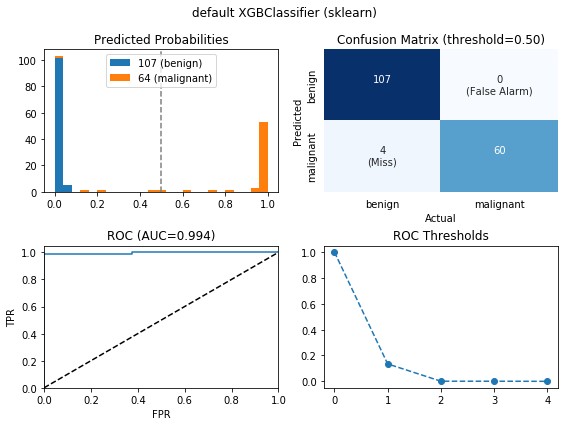

In [6]:
clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)
clf.fit(X_train, y_train)
y_hat = clf.predict_proba(X_test)[:,1]
show_results(y_test, y_hat, labels, title="default XGBClassifier (sklearn)", youden=False)

## XGBoost (sklearn) with default parameters and early stopping

Early stopping prevents overfitting by finding the 'optimal' number of training iterations which maximize a specific target metric (here 'auc') on a validation set.

Attention: The validation set must be different from the training set (to prevent overfitting). Moreover, the test set must not be used, because it is reserved for evaluating the skill of the final model). Therefore, the previously defined training set is split again into a new training set and the validation set.

In [7]:
# split training and validation data
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3, random_state=random_seed)
print("train: ", X_trn.shape, ', val:', X_val.shape)

train:  (278, 30) , val: (120, 30)


best iteration [106] auc=0.984889, logloss=0.138303 (validation)


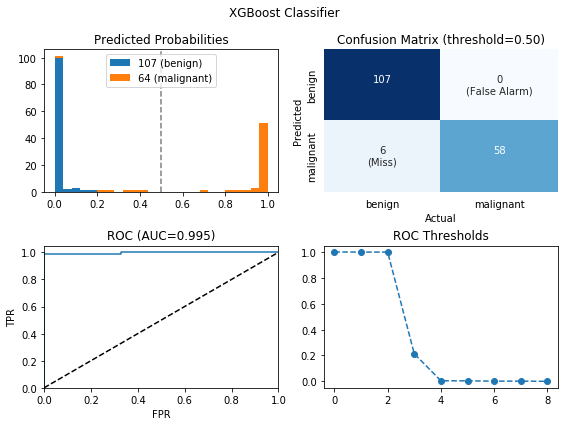

In [8]:
def get_best_round(clf, X_, y_, eval_metric, early_stop=50):
    '''train xgboost and stop when the score on validation set has not improved within X rounds'''
    
    X_, X_val, y_, y_val = train_test_split(X_, y_, stratify=y_, test_size=0.3, random_state=random_seed)
    clf.fit(X_, y_, eval_set=[(X_val, y_val)], eval_metric=eval_metric, early_stopping_rounds=early_stop, verbose=0)
    
    bst = clf.get_booster()
    best_metrics = ", ".join([f"{m}={clf.evals_result()['validation_0'][m][bst.best_iteration]}" for m in eval_metric])
    print(f"best iteration [{bst.best_iteration}] {best_metrics} (validation)")
    
    return bst.best_iteration

metrics=['auc', 'logloss']
clf = XGBClassifier(**params, n_estimators=max_rounds, random_state=random_seed)
best_iteration = get_best_round(clf, X_train, y_train, metrics)

# re-train with best number of iterations using whole training set
clf.set_params(n_estimators=best_iteration+1)
clf.fit(X_train, y_train, verbose=0)

y_hat = clf.predict_proba(X_test)[:,1]
show_results(y_test, y_hat, labels, title="XGBClassifier (default, early stopping)", youden=False)

## XGBoost (sklearn) with Hyperparameter Optimization

In [9]:
# see https://xgboost.readthedocs.io/en/latest/parameter.html
search_space = {
    "max_depth": [3, 4, 5],
    #"min_child_weight": [1.0],
    "subsample": [0.8, 1.0],  # subsample of observations
    "colsample_bytree": [0.8, 1.0],  # subsample of features
    #"lambda": [1.0],      # L2 regularization
    #"alpha": [0.1],  # L1 regularization
    #"min_split_loss": [0.0, 0.5],  # (gamma) minimum loss reduction for further split
    "learning_rate": [0.1, 0.05],
    #"scale_pos_weight": [0.5, 1.0],
}

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   12.3s finished


{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'subsample': 0.8}


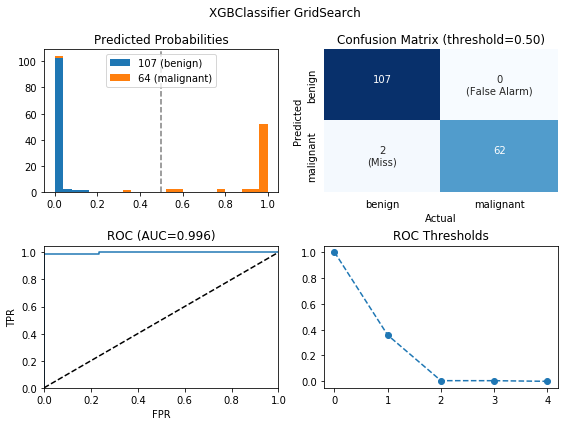

In [10]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost.sklearn import XGBClassifier

clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)

skb = StratifiedKFold(n_splits=5, shuffle=True)

scoring = ['roc_auc']

#print(f"xgb_cv '{key}', shape={X.shape}")
start = time()

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=search_space,
    n_jobs=4,
    cv=skb,
    scoring=scoring,
    verbose=1,
    refit=scoring[0],
    return_train_score=False,
)

fit_gs = grid_search.fit(X_train, y_train)
print(fit_gs.best_params_)

y_hat = fit_gs.predict_proba(X_test)[:,1]
show_results(y_test, y_hat, labels, title="XGBClassifier GridSearch", youden=False)

## XGBoost (native) with default parameters

In [11]:
import xgboost as xgb
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

# prepare training and test data for XGBoost
train = xgb.DMatrix(X_train.values, y_train.values, feature_names=data['feature_names'])
test  = xgb.DMatrix(X_test.values, y_test.values, feature_names=data['feature_names'])

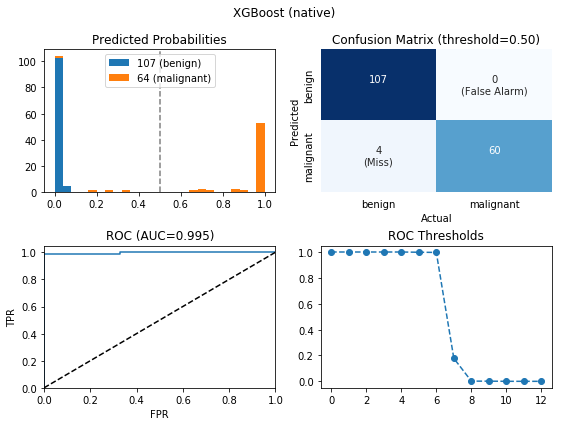

In [12]:
bst = xgb.train(params, train, max_rounds)
y_hat = bst.predict(test)
show_results(y_test, y_hat, labels, title="XGBoost (native)", youden=False)

## XGBoost (native) with default parameters and early stopping

In [13]:
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3, random_state=random_seed)

# prepare training and test data for XGBoost
trn = xgb.DMatrix(X_trn.values, y_trn.values, feature_names=data['feature_names'])
val = xgb.DMatrix(X_val.values, y_val.values, feature_names=data['feature_names'])

best iteration [27] logloss=0.15175


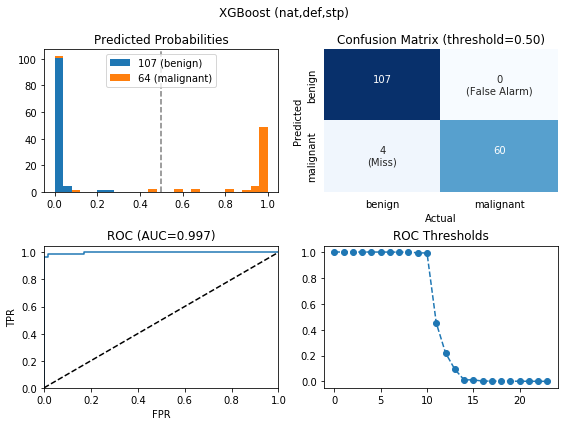

In [14]:
metrics  = ['auc', 'logloss']
eval_set = [(trn, 'train'), (val, 'val')]

bst = xgb.train({**params,'eval_metric':metrics}, trn, max_rounds, evals=eval_set, early_stopping_rounds=early_stop, verbose_eval=0)

print(f"best iteration [{bst.best_iteration}] {metrics[-1]}={bst.best_score}")

best_iteration = bst.best_iteration

# re-train with best number of iterations using whole training set
bst = xgb.train(params, train, best_iteration+1)
y_hat = bst.predict(test)
show_results(y_test, y_hat, labels, title="XGBoost (nat,def,stp)", youden=False)

## XGBoost (native) with default parameters and cross-validated early stopping

best iteration [35] logloss=0.12013


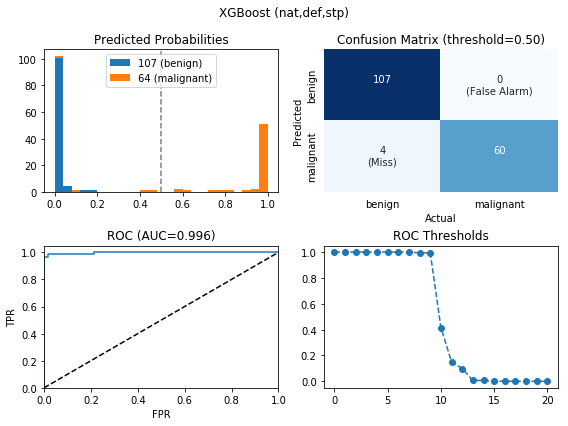

In [15]:
def best_rounds_cv(params, train, max_rounds, early_stop, nfold=5, metrics=['auc']):
    '''find best number of iterations using early stopping with cross validation.
       must only use one metric if 'auc' is the target (otherwise logloss is preferred??!!!)'''
    eval_hist = xgb.cv(params, train, max_rounds, nfold, stratified=True, metrics=metrics, early_stopping_rounds=early_stop, seed=random_seed)
    best_iteration = eval_hist.index[-1]
    best_score = eval_hist[f'test-{metrics[-1]}-mean'].values[-1]
    return (best_iteration, best_score)

best_iteration, best_score = best_rounds_cv(params, train, max_rounds, early_stop, metrics=metrics)
print(f"best iteration [{best_iteration}] {metrics[-1]}={best_score:.5f}")

bst = xgb.train(params, train, best_iteration+1)
y_hat = bst.predict(test)
show_results(y_test, y_hat, labels, title="XGBoost (nat,def,stp)", youden=False)

# PROBLEM:

## Best auc/rounds from grid search differ from cv evaluation of best parameters (if metric is auc)!

In [16]:
# for all metrics see https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
metrics=['auc'] # ['auc', 'logloss'] same as ['logloss', 'auc'] -> must use only ['auc'] for testing 'auc' metric
rounds, best_val = best_rounds_cv(params, train, max_rounds, early_stop=early_stop, metrics=metrics)
print(f'best "{metrics[-1]}" = {best_val:.3f} @ {rounds} rounds')

best "auc" = 0.987 @ 60 rounds


## Hyperparameter Optimization (with native XGBoost)

In [17]:
# see https://xgboost.readthedocs.io/en/latest/parameter.html
search_space = {
    "max_depth": [3, 4, 5],
    #"min_child_weight": [1.0],
    "subsample": [0.8, 1.0],  # subsample of observations
    "colsample_bytree": [0.8, 1.0],  # subsample of features
    #"lambda": [1.0],      # L2 regularization
    #"alpha": [0.1],  # L1 regularization
    #"min_split_loss": [0.0, 0.5],  # (gamma) minimum loss reduction for further split
    "learning_rate": [0.1, 0.05],
    #"scale_pos_weight": [0.5, 1.0],
}

In [18]:
from itertools import product
import math

def grid_search_cv(params, search_space, train, max_rounds=1000, metrics=['aucpr', 'auc', 'logloss'], nfold=5, early_stop=50):
    prod = np.prod([len(search_space[k]) for k in search_space])
    print(f'{nfold} folds x {prod} combinations -> {nfold*prod} fits')

    def param_combinations(p):
        keys = p.keys()
        return [dict(zip(keys, i)) for i in product(*[p[k]for k in keys])]

    results = []
    start = time()
    for p in param_combinations(search_space):
        cv_result = xgb.cv({**params, **p}, train, max_rounds, nfold=nfold, stratified=True, metrics=metrics, early_stopping_rounds=early_stop, seed=random_seed)
        results.append({'params':p, f'test-{metrics[-1]}-mean':cv_result[f'test-{metrics[-1]}-mean'].values[-1], 'iter':len(cv_result)})
    print("-> took %.1f seconds" % (time() - start))
    return results

def plot_hyper_params(df_results, parameters, column, ncols = 4):
    nrows = math.ceil(len(parameters)/ncols)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, figsize=(ncols*2,nrows*2))
    
    for i in range(len(parameters)):
        k = parameters[i]
        ax=axs.ravel()[i]
        df_results.boxplot(ax=ax, column=column, by=k)
        #sns.boxplot(k, 'test-auc-mean', data=df_results, ax=ax, color='Grey')
        ax.set(title=k, xlabel='')
    
    fig.suptitle('')
    fig.tight_layout()

In [19]:
results = grid_search_cv(params, search_space, train, nfold=5, max_rounds=1000)

5 folds x 24 combinations -> 120 fits
-> took 51.3 seconds


In [20]:
df = pd.DataFrame(results)

df_params = pd.DataFrame([{k:v for k,v in i.items()} for i in df.params])
df_params = pd.concat([df, df_params], axis=1, sort=False).sort_values('test-logloss-mean', ascending=True)
display(df_params.head())

,iter,params,test-logloss-mean,colsample_bytree,learning_rate,max_depth,subsample
11,194,"{'max_depth': 4, 'subsample': 0.8, 'colsample_...",0.113765,1.0,0.05,4,0.8
3,247,"{'max_depth': 3, 'subsample': 0.8, 'colsample_...",0.113880,1.0,0.05,3,0.8
10,106,"{'max_depth': 4, 'subsample': 0.8, 'colsample_...",0.116327,1.0,0.10,4,0.8
17,279,"{'max_depth': 5, 'subsample': 0.8, 'colsample_...",0.116460,0.8,0.05,5,0.8
9,218,"{'max_depth': 4, 'subsample': 0.8, 'colsample_...",0.116765,0.8,0.05,4,0.8


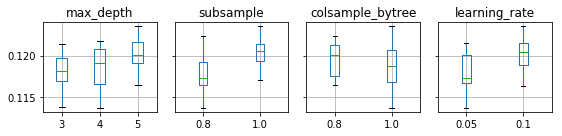

In [21]:
plot_hyper_params(df_params, list(search_space.keys()), 'test-logloss-mean')

best: 194 rounds with {'objective': 'binary:logistic', 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.05}


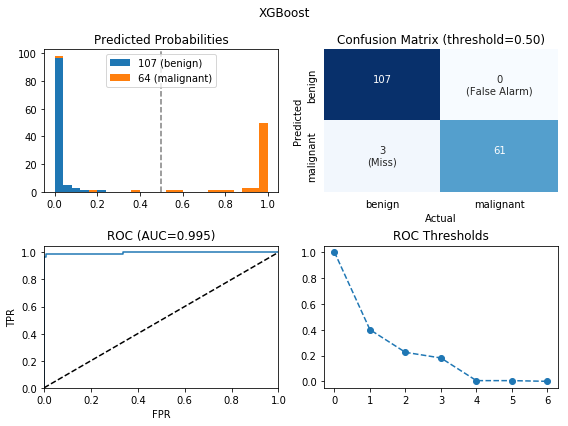

In [22]:
# use best params from hyperparameter optimization
rounds, p = (df_params.iter.values[0], {**params, **df_params.params.values[0]})
print(f"best: {rounds} rounds with {p}")
bst = xgb.train(p, train, rounds)

y_hat = bst.predict(test)
show_results(y_test, y_hat, labels, title="XGBoost", youden=False)

## Compare different approaches for handling imbalanced data

**Note:** The Breast Cancer dataset is only slightly imbalanced. Following section simply demonstrates different approaches.

1. Apply different data re-sampling techniques to balance positive and negative classes (also use [XGBoost parameter optimization](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html))
2. Compare different performance metrics (accuracy is not suitable for imbalanced data)
3. Use Cross validation

In [23]:
# define (suitable) initial XGBoost model parameters
xgb_params = {
    "objective":'binary:logistic',
    #"max_depth": 3,
    #"subsample": 0.3,  # sample observations
    #"colsample_bytree": 0.3,  # sample features
    #"learning_rate": 0.1
}

metrics=["auc", "aucpr", "error", "logloss"] # last metric is used for early stopping

### Define different XGBoost 'Pipeline' configurations

**NOTE:** sklearn pipelines are not applicable - they do not support data resampling and early-stopping in XGBoost.
(https://stackoverflow.com/questions/50824326/xgboost-with-gridsearchcv-scaling-pca-and-early-stopping-in-sklearn-pipeline/)

In [24]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import xgboost as xgb

p['learning_rate']=0.1
max_rounds=1000
print(p)
classifiers = {
    "Default":        (None, p),
    "pos weight 1:5": (None, {**p, "scale_pos_weight": 0.2}),
    "UnderSampled":   (RandomUnderSampler(), p),
    "OverSampled":    (RandomOverSampler(), p),
    "SMOTE":          (SMOTE(), p),
    "ADASYN":         (ADASYN(), p)
}

{'objective': 'binary:logistic', 'max_depth': 4, 'subsample': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.1}


In [25]:
def xgb_eval_cv(X, y, params, rounds=1000, early_stopping_rounds=50, nfold=5, metrics=["logloss", "error", "auc", "aucpr"]):
    """Run XGBoost model training with cross validation and different performance metrics."""
    return xgb.cv(
        params=params,
        dtrain=xgb.DMatrix(X, y),
        stratified=True,
        num_boost_round=rounds,
        early_stopping_rounds=early_stopping_rounds,
        nfold=nfold,
        metrics=metrics,
    )

def xgb_eval_cv_list(X, y, classifiers, rounds=1000, early_stopping=50, nfold=5, metrics=["error", "auc", "aucpr", "logloss"]):

    cv_results = {}
    for key in classifiers.keys():
        scaler, params = classifiers[key]
        X, y = (X_train.values, y_train.values) if scaler is None else scaler.fit_resample(X_train, y_train)

        print(f"xgb_cv '{key}', shape={X.shape}")
        start = time()
        cv_results[key] = xgb_eval_cv(X, y, params, rounds, early_stopping, nfold, metrics)
        print("-> took %.1f seconds" % (time() - start))
    
    return cv_results

In [26]:
def plot_cv_results(cv_results, labels=["train", "val"]):
    """plot results of multiple cross validation runs with different metrics."""

    def plot_band(ax, mean, std, label=None, color="b"):
        ax.fill_between(
            mean.index.values, mean - std, mean + std, color=color, alpha=0.3
        )
        ax.plot(mean, color=color, label=label)

    # create multi-index
    keys = list(cv_results.keys())
    for col in range(len(keys)):
        cv = cv_results[keys[col]]
        if not isinstance(cv.columns, pd.MultiIndex):
            cv.columns = cv.columns.str.split("-", expand=True)
    
    metrics = next(iter(cv_results.values())).columns.unique(1).values

    fig, axs = plt.subplots(
        nrows=len(metrics), ncols=len(keys), figsize=(1 + len(keys) * 2, len(metrics)*2)
    )
    axs = axs.flatten()

    for col in range(len(keys)):
        cv = cv_results[keys[col]]

        for row in range(len(metrics)):
            
            
            idx = row * len(keys) + col
            plot_band(
                axs[idx],
                cv[("train", metrics[row], "mean")],
                cv[("train", metrics[row], "std")],
                color="purple",
                label=labels[0] + (" (%.3f)" % (cv[("train", metrics[row], "mean")].values[-1]))
            )
            plot_band(
                axs[idx],
                cv[("test", metrics[row], "mean")],
                cv[("test", metrics[row], "std")],
                color="sandybrown",
                label=labels[1] + (" (%.3f)" % (cv[("test", metrics[row], "mean")].values[-1])),
            )
            axs[idx].grid(b=True, which="both", color="0.75", linestyle="-")
            axs[idx].legend()
            if metrics[row] in ["auc", "aucpr"]:
                axs[idx].set_ylim(0.9, 1.01)
            if metrics[row] in ["error"]:
                axs[idx].set_ylim(0, 0.2)
            if metrics[row] in ["logloss"]:
                axs[idx].set_ylim(0, 0.8)
            if col == 0:
                axs[idx].set_ylabel(metrics[row], rotation=0, size="large", ha="right")
            axs[idx].legend(prop={'size': 8})

    for ax, col in zip(axs[0 : len(keys)], keys):
        ax.set_title(col)
    fig.tight_layout()
    fig.suptitle("Cross Validation Learning Rates")
    fig.subplots_adjust(top=0.83+0.02*len(metrics))

In [27]:
cv_results = xgb_eval_cv_list(X_train, y_train, classifiers, rounds=max_rounds, early_stopping=early_stop)

xgb_cv 'Default', shape=(398, 30)
-> took 5.6 seconds
xgb_cv 'pos weight 1:5', shape=(398, 30)
-> took 4.5 seconds
xgb_cv 'UnderSampled', shape=(296, 30)
-> took 3.5 seconds
xgb_cv 'OverSampled', shape=(500, 30)
-> took 6.7 seconds
xgb_cv 'SMOTE', shape=(500, 30)
-> took 6.0 seconds
xgb_cv 'ADASYN', shape=(508, 30)
-> took 9.3 seconds


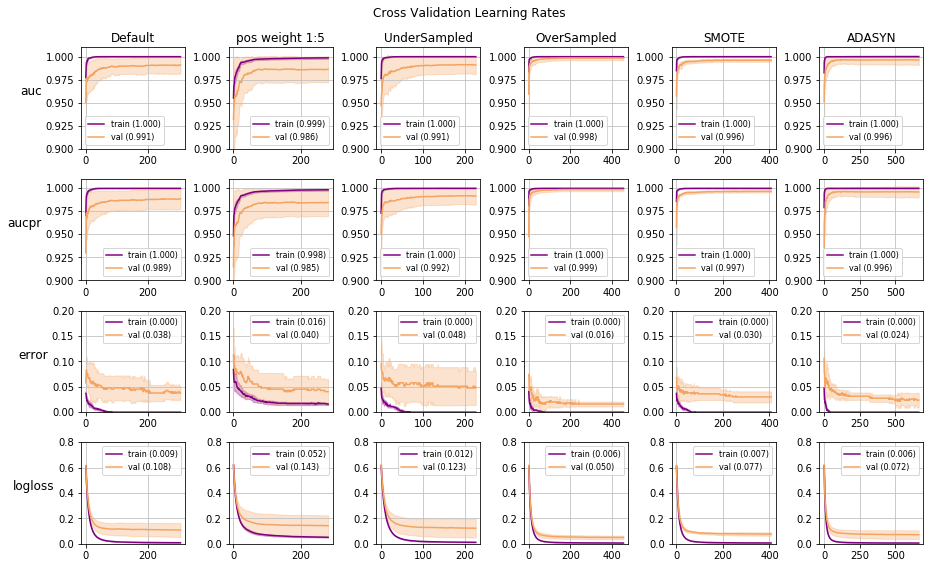

In [28]:
plot_cv_results(cv_results)

# Resampling with Hyper Parameter Tuning

In [29]:
params = {
    'objective':'binary:logistic'
}

classifiers = [
    ('Default', None),
    ('OverSampled', RandomOverSampler(random_state=random_seed)),
    ('SMOTE',   SMOTE(random_state=random_seed)),
    ('ADASYN',  ADASYN(random_state=random_seed))
]

xgb_grid_search_params = {
    "max_depth": [3, 4, 5],
    #"min_child_weight": [1.0],
    "subsample": [0.6],  # subsample of observations
    "colsample_bytree": [0.3, 0.4],  # subsample of features
    #"lambda": [1.0],      # L2 regularization
    #"alpha": [0.1],  # L1 regularization
    "gamma": [0, 0.2, 0.4],  # minimum loss reduction for further split
    "learning_rate": [0.1, 0.05, 0.01],
}

Optimizing "Default"
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   30.8s finished


{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
Optimizing "OverSampled"
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   35.2s finished


{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
Optimizing "SMOTE"
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   29.7s finished


{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
Optimizing "ADASYN"
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   32.3s finished


{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}


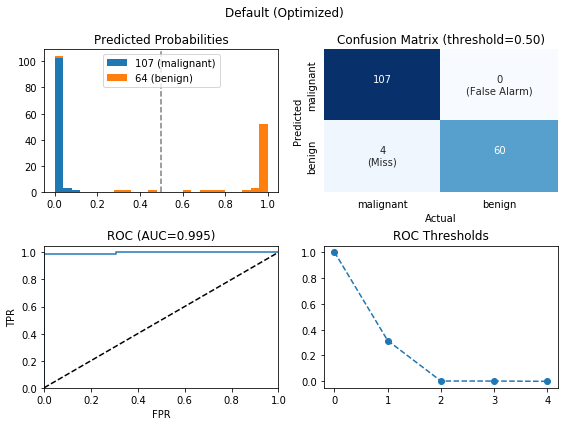

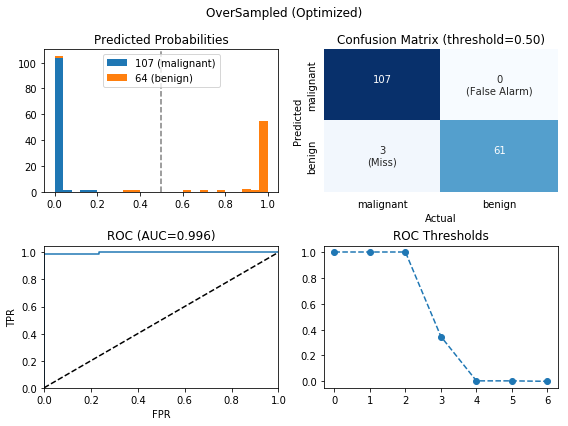

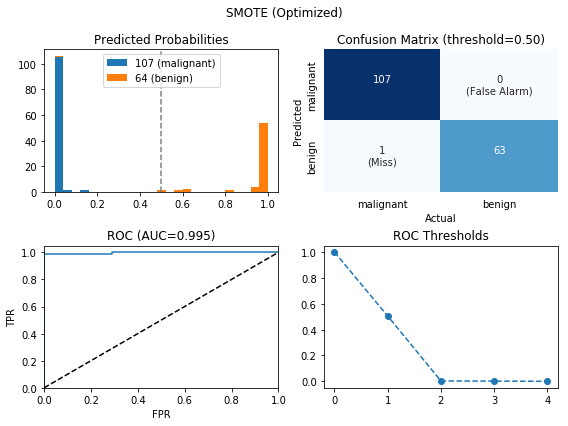

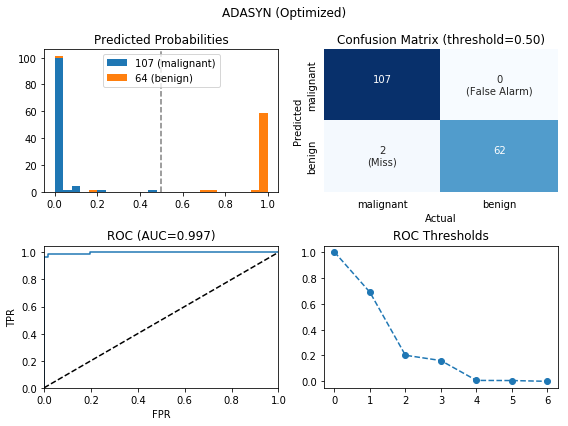

In [30]:
scoring = ['neg_log_loss','roc_auc']
skb = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

best_params = {}
for name, scaler in classifiers:
    print(f'Optimizing "{name}"')
    
    X_, y_ = X_train, y_train
    if scaler:
        X_resampled, y_resampled = scaler.fit_resample(X_train, y_train)
        X_, y_ = pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled)
    
    clf = XGBClassifier(n_estimators=max_rounds, **params, random_state=random_seed)

    start = time()

    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=search_space,
        n_jobs=4,
        cv=skb,
        scoring=scoring,
        verbose=1,
        iid=False,
        refit=scoring[0],
        return_train_score=False
    )

    fit_gs = grid_search.fit(X_, y_)
    best_params[name] = fit_gs.best_params_
    print(fit_gs.best_params_)

    y_hat = fit_gs.predict_proba(X_test)[:,1]
    show_results(y_test, y_hat, data['target_names'], title=f'{name} (Optimized)', youden=False)

In [31]:
for name, params in best_params.items():
    print(f'{name:10s} {params}')

Default    {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
OverSampled {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
SMOTE      {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
ADASYN     {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}


# Repeated Grid Search

In [32]:
from sklearn.metrics import f1_score, classification_report, roc_curve, roc_auc_score, auc, matthews_corrcoef, accuracy_score, confusion_matrix, precision_score, recall_score

rounds = 10
results =[]
best_clfs = []

start = time()
for i in range(rounds):
    print(f">>> ROUND {i+1}/{rounds}:")
    
    # create new classifier, folds and grid search - should use different random seeds
    clf = XGBClassifier(n_estimators=max_rounds, **params)
    skb = StratifiedKFold(n_splits=5, shuffle=True)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=search_space,
        n_jobs=4,
        cv=skb,
        scoring=scoring,
        verbose=1,
        refit=scoring[0],
        return_train_score=False
    )
    
    fit = grid_search.fit(X_train, y_train)
    
    best_clfs.append(grid_search.best_estimator_)
    
    y_hat = grid_search.predict_proba(X_test)[:,1] # uses best estimator
    y_prd = y_hat >= 0.5
    tn, fp, fn, tp = confusion_matrix(y_test, y_prd).ravel()
    
    results.append({
        'params'  : fit.best_params_,
        'auc'     : roc_auc_score(y_test, y_hat),
        'f1'      : f1_score(y_test, y_prd),
        'mcc'     : matthews_corrcoef(y_test, y_prd),
        'accuracy': accuracy_score(y_test, y_prd) * 100,
        'precision': precision_score(y_test, y_prd) * 100,
        'recall'  : recall_score(y_test, y_prd) * 100,
        'fn'      : fn,
        'fp'      : fp
    })

print("took %.1f seconds" % (time() - start))

>>> ROUND 1/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   24.0s finished


>>> ROUND 2/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   24.4s finished
/home/goerlitz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


>>> ROUND 3/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   25.2s finished


>>> ROUND 4/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   24.4s finished
/home/goerlitz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


>>> ROUND 5/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   25.1s finished
/home/goerlitz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


>>> ROUND 6/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   24.0s finished
/home/goerlitz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


>>> ROUND 7/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   24.8s finished
/home/goerlitz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


>>> ROUND 8/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   24.6s finished
/home/goerlitz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


>>> ROUND 9/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   24.4s finished


>>> ROUND 10/10:
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   23.4s finished
/home/goerlitz/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


took 249.1 seconds


In [33]:
import json

# convert param dict to string and group by params
df_results = pd.DataFrame(results)
df_results.params = df_results.params.apply(lambda x: json.dumps(x))

metrics=['mean']
agg_metrics = {'params':['count'], **{i:metrics for i in df_results.columns if i != 'params'}}
df_results.groupby('params').agg(agg_metrics).sort_values(('accuracy','mean'), ascending=False)

,params,accuracy,auc,f1,fn,fp,mcc,precision,recall
,count,mean,mean,mean,mean,mean,mean,mean,mean
params,,,,,,,,,
"{""colsample_bytree"": 1.0, ""learning_rate"": 0.05, ""max_depth"": 3, ""subsample"": 0.8}",1,98.245614,0.994597,0.976000,3,0,0.962876,100.0,95.3125
"{""colsample_bytree"": 0.8, ""learning_rate"": 0.05, ""max_depth"": 3, ""subsample"": 0.8}",3,97.660819,0.995035,0.967742,4,0,0.950640,100.0,93.7500
"{""colsample_bytree"": 0.8, ""learning_rate"": 0.05, ""max_depth"": 4, ""subsample"": 0.8}",1,97.660819,0.995327,0.967742,4,0,0.950640,100.0,93.7500
"{""colsample_bytree"": 0.8, ""learning_rate"": 0.05, ""max_depth"": 5, ""subsample"": 0.8}",1,97.660819,0.995035,0.967742,4,0,0.950640,100.0,93.7500
"{""colsample_bytree"": 0.8, ""learning_rate"": 0.1, ""max_depth"": 3, ""subsample"": 0.8}",1,97.660819,0.993429,0.967742,4,0,0.950640,100.0,93.7500
"{""colsample_bytree"": 1.0, ""learning_rate"": 0.05, ""max_depth"": 5, ""subsample"": 0.8}",1,97.660819,0.994597,0.967742,4,0,0.950640,100.0,93.7500
"{""colsample_bytree"": 1.0, ""learning_rate"": 0.1, ""max_depth"": 4, ""subsample"": 1.0}",1,97.660819,0.995181,0.967742,4,0,0.950640,100.0,93.7500
"{""colsample_bytree"": 1.0, ""learning_rate"": 0.1, ""max_depth"": 5, ""subsample"": 0.8}",1,97.660819,0.995473,0.967742,4,0,0.950640,100.0,93.7500


#### Misclassified instances

In [34]:
print('IDs of misclassified instances')
for i, clf in enumerate(best_clfs):
    y_hat = clf.predict_proba(X_test)[:,1]
    print(i, ':', y_test[y_test != (y_hat >= 0.5)].index.values)

IDs of misclassified instances
0 : [205   5  86  73]
1 : [205  73 385]
2 : [205   5  73 385]
3 : [205   5  73 385]
4 : [205   5  73 385]
5 : [205   5  73 385]
6 : [205   5  73 385]
7 : [205   5  73 385]
8 : [205   5  73 385]
9 : [205   5  73 385]


#### ROC Variation

(0.45, 1.01)

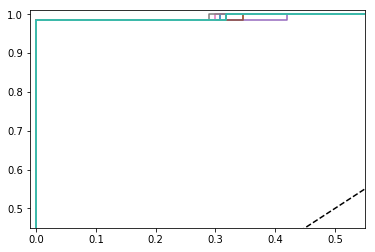

In [35]:
for clf in best_clfs:
    y_hat = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thres = roc_curve(y_test, y_hat)
    plt.plot(fpr, tpr)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim((-0.01, 0.55))
plt.ylim((0.45,1.01))